In [ ]:
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
!pip install scikeras

# 공통

In [1]:
import numpy as np
import pandas as pd

from sklearn.ensemble import AdaBoostRegressor
from scikeras.wrappers import KerasRegressor
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from scipy import stats

import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings(action='ignore')
plt.rc('font', family='NanumBarunGothic')

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout, InputLayer
from tensorflow.keras.callbacks import EarlyStopping

In [3]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epoch = range(len(loss))

    plt.plot(epoch, loss, color='steelblue', label='Traing loss')
    plt.plot(epoch, val_loss, color='darkorange', label='Validation loss')
    plt.title(title)
    plt.legend()
    plt.show()

In [4]:
def make_sequence_dataset(feature, label, window_size):
  feature_list = []
  label_list = []

  for i in range(len(feature)-window_size):
    feature_list.append(feature[i:i+window_size])
    label_list.append(label[i+window_size])

  return np.array(feature_list), np.array(label_list)

# 탐색

In [4]:
df = pd.read_csv('/content/drive/MyDrive/불꽃냥펀치/scfi_lstm.csv')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 582 entries, 0 to 581
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   주차      582 non-null    object 
 1   SCFI    582 non-null    float64
 2   코로나확진자  582 non-null    float64
 3   환율      582 non-null    float64
 4   WTI유가   582 non-null    float64
 5   나프타유가   582 non-null    float64
 6   고유황중유가  582 non-null    float64
dtypes: float64(6), object(1)
memory usage: 32.0+ KB


In [6]:
print('                 pearsonr을 알아보자')
print('*'*54)
print(f"SCFI & 코로나확진자 : {np.round(stats.pearsonr(df['SCFI'], df['코로나확진자'])[0],3)}, SCFI & 코로나확진자 : {np.round(stats.pearsonr(df['SCFI'], df['코로나확진자'])[1],3)}")
print('-'*54)
print(f"SCFI & 환율         : {np.round(stats.pearsonr(df['SCFI'], df['환율'])[0],3)},         SCFI & 환율 : {np.round(stats.pearsonr(df['SCFI'], df['환율'])[1],3)}")
print('-'*54)
print(f"SCFI & WTI유가      : {np.round(stats.pearsonr(df['SCFI'], df['WTI유가'])[0],3)},      SCFI & WTI유가 : {np.round(stats.pearsonr(df['SCFI'], df['WTI유가'])[1],3)}")
print('-'*54)
print(f"SCFI & 나프타유가   : {np.round(stats.pearsonr(df['SCFI'], df['나프타유가'])[0],3)},   SCFI & 나프타유가 : {np.round(stats.pearsonr(df['SCFI'], df['나프타유가'])[1],3)}")
print('-'*54)
print(f"SCFI & 고유황중유가 : {np.round(stats.pearsonr(df['SCFI'], df['고유황중유가'])[0],3)}, SCFI & 고유황중유가 : {np.round(stats.pearsonr(df['SCFI'], df['고유황중유가'])[1],3)}")

                 pearsonr을 알아보자
******************************************************
SCFI & 코로나확진자 : 0.628, SCFI & 코로나확진자 : 0.0
------------------------------------------------------
SCFI & 환율         : 0.238,         SCFI & 환율 : 0.0
------------------------------------------------------
SCFI & WTI유가      : 0.377,      SCFI & WTI유가 : 0.0
------------------------------------------------------
SCFI & 나프타유가   : 0.327,   SCFI & 나프타유가 : 0.0
------------------------------------------------------
SCFI & 고유황중유가 : 0.345, SCFI & 고유황중유가 : 0.0


In [7]:
scaler1 = StandardScaler()
df_plot = scaler1.fit_transform(df.drop(columns=['주차']))

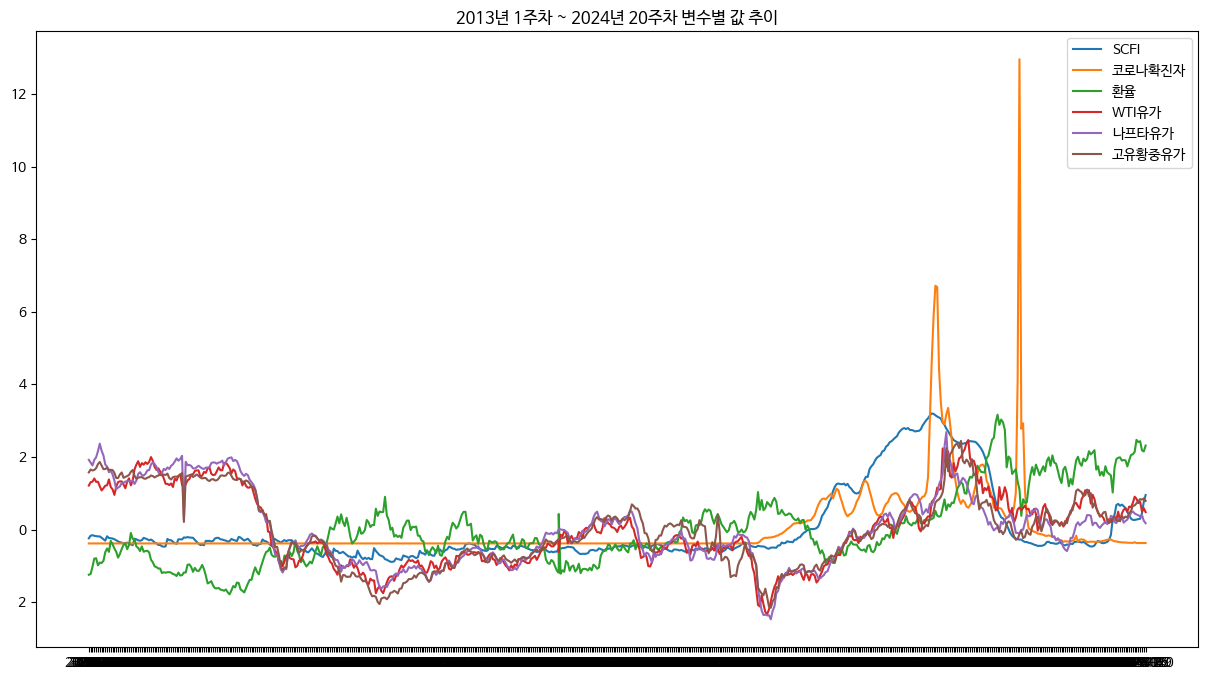

In [8]:
plt.figure(figsize=(15, 8))
plt.plot(df['주차'], df_plot[:,0], label='SCFI')
plt.plot(df['주차'], df_plot[:,1], label='코로나확진자')
plt.plot(df['주차'], df_plot[:,2], label='환율')
plt.plot(df['주차'], df_plot[:,3], label='WTI유가')
plt.plot(df['주차'], df_plot[:,4], label='나프타유가')
plt.plot(df['주차'], df_plot[:,5], label='고유황중유가')
plt.title('2013년 1주차 ~ 2024년 20주차 변수별 값 추이')
plt.legend()
plt.show()

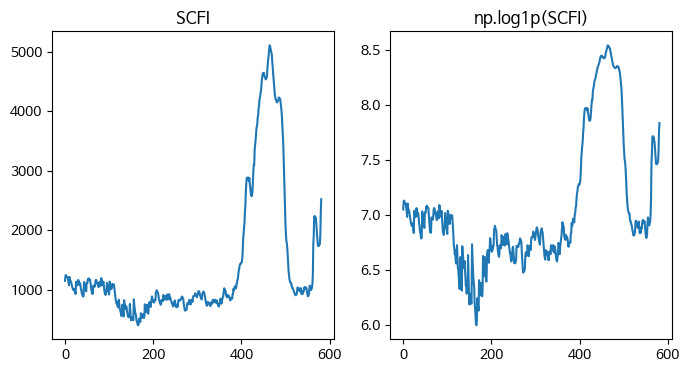

In [9]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(df['SCFI'])
plt.title('SCFI')
plt.subplot(1, 2, 2)
plt.plot(np.log1p(df['SCFI']))
plt.title('np.log1p(SCFI)')

plt.show()

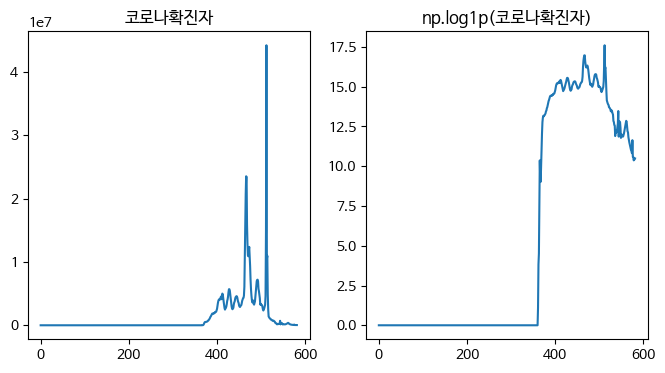

In [10]:
plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.plot(df['코로나확진자'])
plt.title('코로나확진자')
plt.subplot(1, 2, 2)
plt.plot(np.log1p(df['코로나확진자']))
plt.title('np.log1p(코로나확진자)')

plt.show()

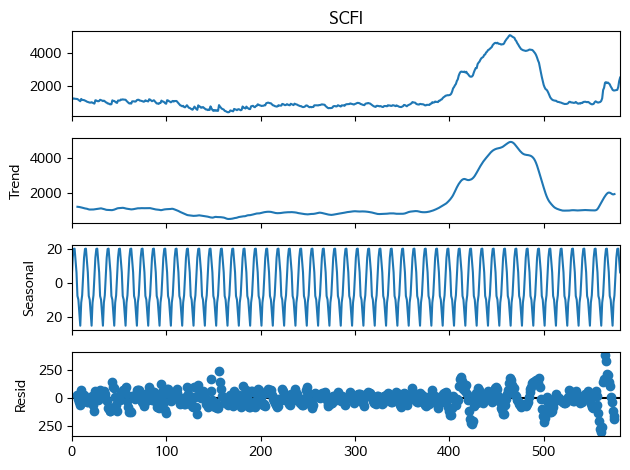

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose

res = seasonal_decompose(df['SCFI'], period=12)
res.plot()
plt.show()

# GRU

In [9]:
df = pd.read_csv('/content/drive/MyDrive/불꽃냥펀치/scfi_lstm.csv')

window_size = 4
split = -100

df.set_index('주차', inplace=True)
df['SCFI'] = np.log1p(df['SCFI'])

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

df_x = df.drop(columns=['SCFI'])
df_y = df[['SCFI']]

feature_np = scaler_x.fit_transform(df_x)
label_np = scaler_y.fit_transform(df_y)

X, Y = make_sequence_dataset(feature_np, label_np, window_size)

print(X.shape) # batch_size, time steps, input dims
print(Y.shape)

x_train = X[0:split]
y_train = Y[0:split]
x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape) # len - split, window_size, feature
print(x_test.shape, y_test.shape) # split, window_size, feature

(578, 4, 5)
(578, 1)
(478, 4, 5) (478, 1)
(100, 4, 5) (100, 1)


In [10]:
# 모델 빌드
model_gru = Sequential()

# GRU 레이어 추가
model_gru.add(GRU(50, activation='relu', return_sequences=True, input_shape=x_train[0].shape))
model_gru.add(GRU(25, activation='relu', return_sequences=True))
model_gru.add(GRU(10, activation='relu'))  # 여기서는 return_sequences를 False로 설정합니다.

# 출력 레이어
model_gru.add(Dense(1, activation='linear'))

# 모델 컴파일
model_gru.compile(optimizer='adam', loss='mse')

model_gru.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 4, 50)             8550      
                                                                 
 gru_1 (GRU)                 (None, 4, 25)             5775      
                                                                 
 gru_2 (GRU)                 (None, 10)                1110      
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 15446 (60.34 KB)
Trainable params: 15446 (60.34 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
model_gru.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=2)

model_gru_history = model_gru.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          epochs=100,
          batch_size=32,
          callbacks=[early_stop])

pred = model_gru.predict(x_test)

Epoch 1/100
15/15 [==============================] - 8s 68ms/step - loss: 0.1579 - val_loss: 0.1247
Epoch 2/100
15/15 [==============================] - 0s 26ms/step - loss: 0.0592 - val_loss: 0.0334
Epoch 3/100
15/15 [==============================] - 0s 25ms/step - loss: 0.0456 - val_loss: 0.0316
Epoch 4/100
15/15 [==============================] - 0s 27ms/step - loss: 0.0410 - val_loss: 0.0312
Epoch 5/100
15/15 [==============================] - 0s 25ms/step - loss: 0.0390 - val_loss: 0.0289
Epoch 6/100
15/15 [==============================] - 0s 26ms/step - loss: 0.0364 - val_loss: 0.0284
Epoch 7/100
15/15 [==============================] - 0s 27ms/step - loss: 0.0330 - val_loss: 0.0374
Epoch 8/100
4/4 [==============================] - 0s 5ms/step


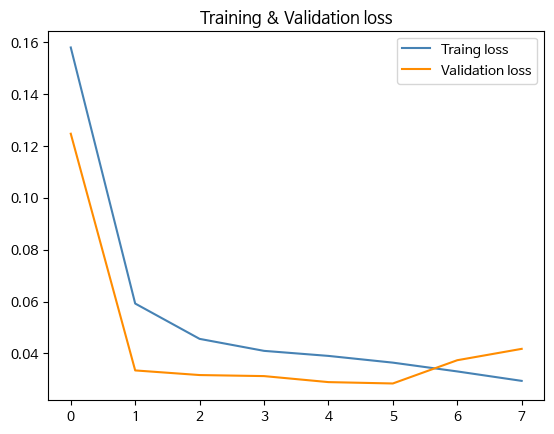

In [12]:
plot_train_history(history=model_gru_history, title='Training & Validation loss')

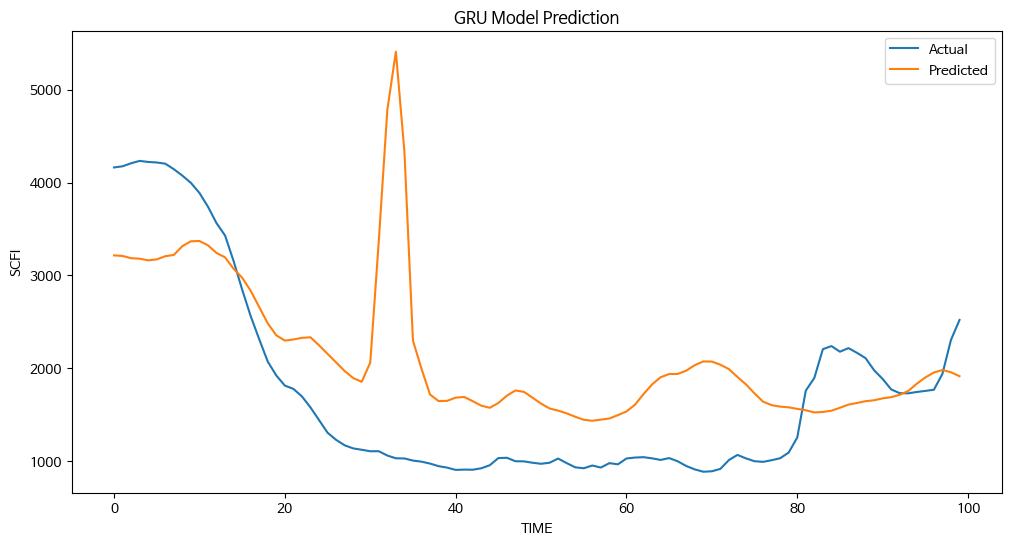

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(np.expm1(scaler_y.inverse_transform(y_test)), label='Actual')
plt.plot(np.expm1(scaler_y.inverse_transform(pred)), label='Predicted')
plt.title('GRU Model Prediction')
plt.xlabel('TIME')
plt.ylabel('SCFI')
plt.legend()
plt.show()

In [69]:
print(f'RMSE: {np.sqrt(mean_squared_error(np.expm1(scaler_y.inverse_transform(y_test)), np.expm1(scaler_y.inverse_transform(pred))))}')
print(f'MAE : {mean_absolute_error(np.expm1(scaler_y.inverse_transform(y_test)), np.expm1(scaler_y.inverse_transform(pred)))}')
print(f'R2  : {r2_score(np.expm1(scaler_y.inverse_transform(y_test)), np.expm1(scaler_y.inverse_transform(pred)))}')

RMSE: 1669.0952949760997
MAE : 807.0657445800782
R2  : -1.5234312681571374


# ada-GRU

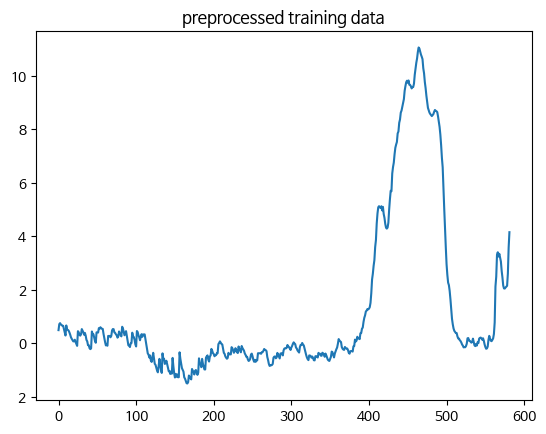

In [26]:
df = pd.read_csv('/content/drive/MyDrive/불꽃냥펀치/scfi_lstm.csv')

scaler = RobustScaler()
training_data = scaler.fit_transform(df[['SCFI']]).reshape(-1,1)
plt.plot(training_data)
plt.title('preprocessed training data')
plt.show()

In [27]:
def make_dataset(training_data, t, h=0, test_size=0.2):

    X_train = []
    y_train = []
    for i in range(t, len(training_data)-h):
        X_train.append(training_data[i-t:i])
        y_train.append(training_data[i+h])
    X = np.array(X_train)
    y = np.array(y_train)

    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    return X_train,X_test,y_train,y_test

In [28]:
X_train,X_test,y_train,y_test = make_dataset(training_data=training_data, t=4, h=0, test_size=0.2)

In [29]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(GRU(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [30]:
GRU_Predictors = KerasRegressor(build_fn=lambda:model, epochs=20, batch_size=30)
final_model = AdaBoostRegressor(GRU_Predictors, n_estimators=5, random_state=42)

Epoch 1/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 6.9778
Epoch 2/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.9721
Epoch 3/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.5944
Epoch 4/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.2663
Epoch 5/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.2417
Epoch 6/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.2012
Epoch 7/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.1801
Epoch 8/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 0.1503
Epoch 9/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1424
Epoch 10/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1792
Epoch 11/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.2019
Epoch 12/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.1926
Epoch 13/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.1343
Epoch 14/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1906
Epoch 15/20
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.1136
Epoch

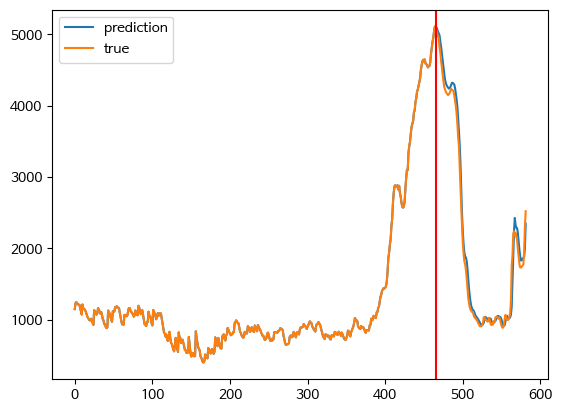

In [31]:
final_model.fit(X_train,y_train)

preds = final_model.predict(X_test)
preds = scaler.inverse_transform(preds.reshape(-1,1))
preds_series = np.hstack([df['SCFI'][:-len(preds)], preds.squeeze(1)])

plt.plot(preds_series, label='prediction')
plt.plot(df['SCFI'], label='true')
plt.axvline(x=len(df['SCFI'])-len(preds), color='r')
plt.legend()
plt.show()

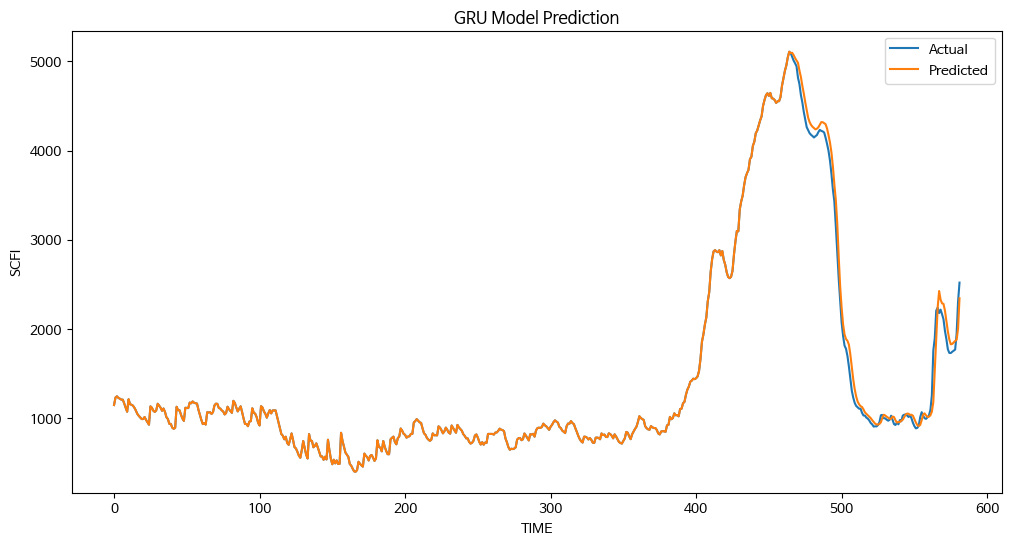

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(df['SCFI'], label='Actual')
plt.plot(preds_series, label='Predicted')
plt.title('GRU Model Prediction')
plt.xlabel('TIME')
plt.ylabel('SCFI')
plt.legend()
plt.show()

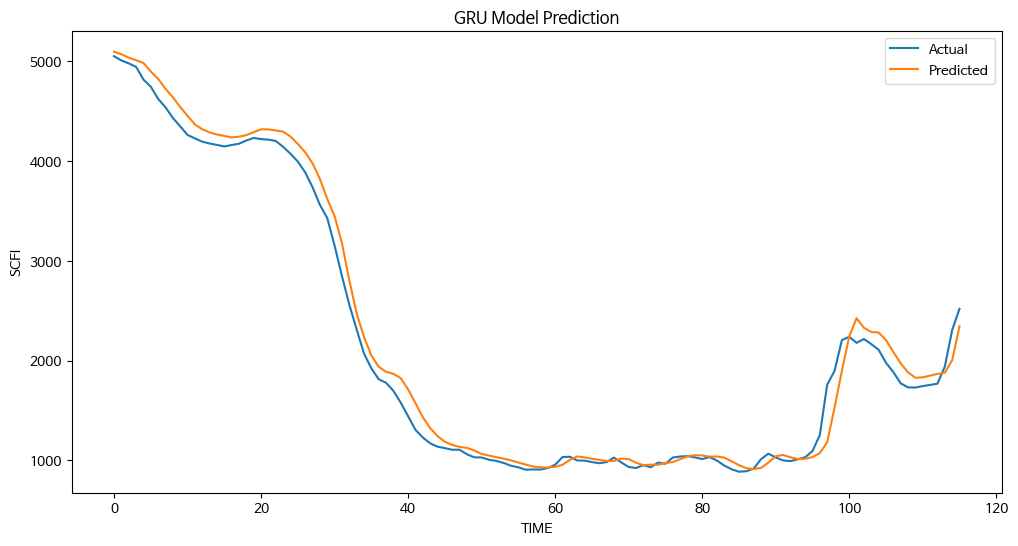

In [34]:
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(y_test), label='Actual')
plt.plot(preds, label='Predicted')
plt.title('GRU Model Prediction')
plt.xlabel('TIME')
plt.ylabel('SCFI')
plt.legend()
plt.show()

In [36]:
print(f'RMSE: {np.sqrt(mean_squared_error(scaler.inverse_transform(y_test), preds))}')
print(f'MAE : {mean_absolute_error(scaler.inverse_transform(y_test), preds)}')
print(f'R2  : {r2_score(scaler.inverse_transform(y_test), preds)}')

RMSE: 145.70392186795956
MAE : 110.55491549787854
R2  : 0.9888275666660117


In [ ]:
# minmax
# RMSE: 151.6240988420637
# MAE : 120.32571057549839
# R2  : 0.9879012151475256

In [ ]:
# robust
# RMSE: 145.70392186795956
# MAE : 110.55491549787854
# R2  : 0.9888275666660117

# ada-GRU-1

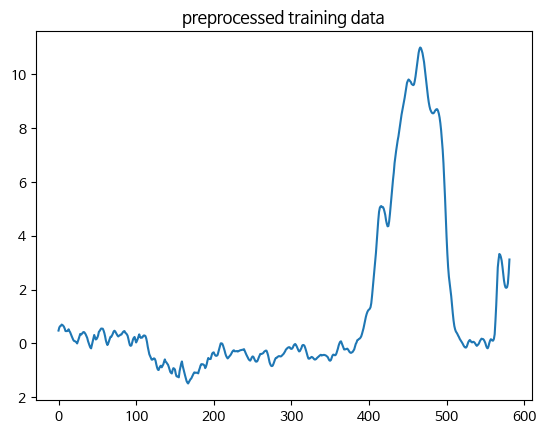

In [133]:
df = pd.read_csv('/content/drive/MyDrive/불꽃냥펀치/scfi_lstm.csv')

# rolling(4, min_periods=0).mean() : 이동평균, 4개의 값의 평균값을 반환한다.
# RobustScaler : 이상치의 영향을 조금이나마 줄이기 위한 중앙값사용 스케일링.
# reshape(-1, 1) : (?행, 1열)을 만들어줬다.
scaler = RobustScaler()
training_data = scaler.fit_transform(df[['SCFI']].rolling(4, min_periods=0).mean()).reshape(-1,1)


# 대충 우리가 사용할 데이터의 모양. 스케일링 된 값을 확일 할 수 있다.
plt.plot(training_data)
plt.title('preprocessed training data')
plt.show()

In [134]:
# training_data : 데이터 배열
# t : window_size와 비슷한 개념, 분리할 데이터
# h : 0이면 singlestep이다, 예측할 데이터
# test_size : 우리가 아는 그거
def make_dataset(training_data, t, h=0, test_size=0.2):

    X_train = []
    y_train = []
    for i in range(t, len(training_data)-h):
        X_train.append(training_data[i-t:i])
        y_train.append(training_data[i+h])
    X = np.array(X_train)
    y = np.array(y_train)

    # 데이터의 시계열을 보존하기 위한 shuffle=False
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

    return X_train,X_test,y_train,y_test

In [135]:
# 4개 단위로 자르고, 다음 1개를 예측한다.
X_train,X_test,y_train,y_test = make_dataset(training_data=training_data, t=4, h=0, test_size=0.2)

# X = (x0,x1,...,x(t-1)), y = x(t+h)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(462, 4, 1) (462, 1)
(116, 4, 1) (116, 1)


In [136]:
model = Sequential()
model.add(InputLayer(input_shape=(X_train.shape[1],1)))
model.add(GRU(units=128))
model.add(Dropout(0.5))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [137]:
GRU_Predictors = KerasRegressor(build_fn=lambda:model, epochs=10, batch_size=32)
final_model = AdaBoostRegressor(GRU_Predictors, n_estimators=300, random_state=99)

In [138]:
final_model.fit(X_train,y_train)

Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 6.3827
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 1.2871
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.4611
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2678
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2631
Epoch 6/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.2004
Epoch 7/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1548
Epoch 8/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.2155
Epoch 9/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.1188
Epoch 10/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.1296
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
Epoch 1/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3235
Epoch 2/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2840
Epoch 3/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.2214
Epoch 4/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.2203
Epoch 5/10
15/15 ━━━━━━━━━━━━━━━━━━━━ 0

AdaBoostRegressor(estimator=KerasRegressor(batch_size=32, build_fn=<function <lambda> at 0x7fa45d32a560>, epochs=10),
                  n_estimators=300, random_state=99)

In [139]:
# 예측
preds = final_model.predict(X_test)
# inverse를 통해 원본 값으로 돌려줬다.
preds = scaler.inverse_transform(preds.reshape(-1,1))
# np.hstack은 배열을 가로로 쌓아준다. 예측 이전 시점의 값들이랑 합쳐주는 작업이다.
preds_series = np.hstack([df['SCFI'][:-len(preds)], preds.squeeze(1)])

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
4/4 ━━━━━━━━

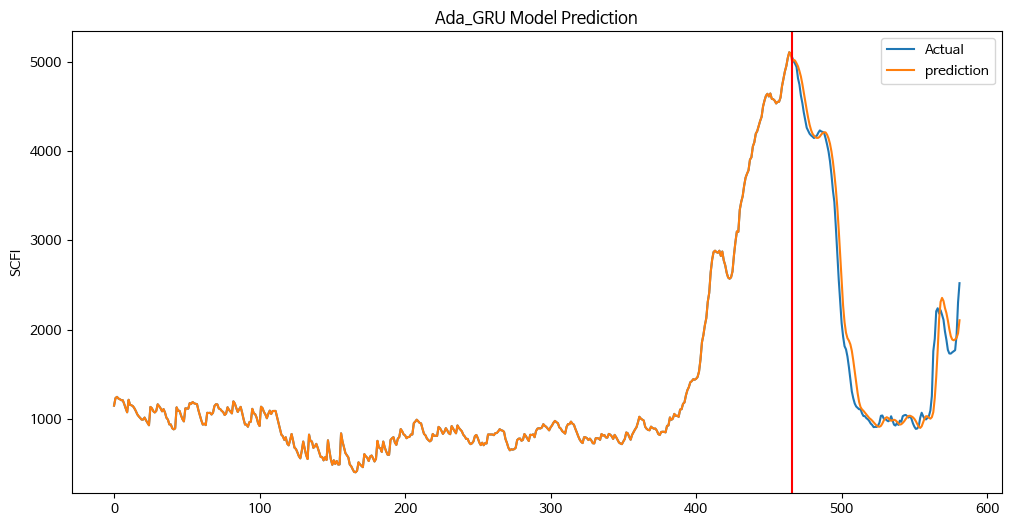

In [140]:
plt.figure(figsize=(12, 6))
plt.plot(df['SCFI'], label='Actual') # 실제
plt.plot(preds_series, label='prediction') # 예측
plt.axvline(x=len(df['SCFI'])-len(preds), color='r') # 예측 시점 구분선
plt.ylabel('SCFI')
plt.title('Ada_GRU Model Prediction')
plt.legend()
plt.show()

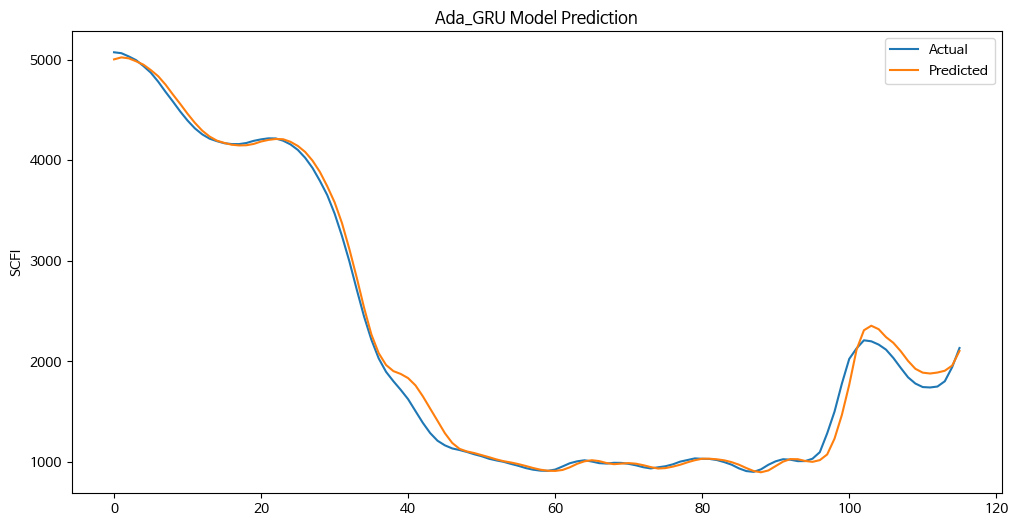

In [141]:
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(y_test), label='Actual') # 실제 test
plt.plot(preds, label='Predicted') # 예측 test
plt.ylabel('SCFI')
plt.title('Ada_GRU Model Prediction')
plt.legend()
plt.show()

In [142]:
print(f'RMSE: {np.sqrt(mean_squared_error(scaler.inverse_transform(y_test), preds))}')
print(f'MAE : {mean_absolute_error(scaler.inverse_transform(y_test), preds)}')
print(f'R2  : {r2_score(scaler.inverse_transform(y_test), preds)}')

RMSE: 93.84639341042083
MAE : 62.2271739670326
R2  : 0.995594738752942


In [143]:
# minmax
# RMSE: 151.6240988420637
# MAE : 120.32571057549839
# R2  : 0.9879012151475256

In [144]:
# robust
# RMSE: 145.70392186795956
# MAE : 110.55491549787854
# R2  : 0.9888275666660117

In [145]:
# robust rolling=4
# RMSE: 126.48022067926189
# MAE : 92.47749631684403
# R2  : 0.9919983099635501

In [146]:
# robust rolling=4 gru eopch=30 ada n_estimators=200 batch_size=32
# RMSE: 106.85389879559231
# MAE : 71.81610065328667
# R2  : 0.9942889331918855

In [147]:
# robust rolling=4 gru eopch=20 ada n_estimators=200 batch_size=32
# RMSE: 114.55095919400404
# MAE : 81.40398485907194
# R2  : 0.9934365231939996

In [148]:
# robust rolling=4 gru eopch=20 ada n_estimators=300 batch_size=32
# RMSE: 97.69978742917614
# MAE : 67.09261118921742
# R2  : 0.9952255457931687

In [149]:
# robust rolling=4 gru eopch=30 ada n_estimators=300 batch_size=32
# RMSE: 112.81640708892618
# MAE : 77.25946322737072
# R2  : 0.9936337890748884

In [ ]:
# robust rolling=4 gru eopch=10 ada n_estimators=300 batch_size=32
# RMSE: 93.84639341042083
# MAE : 62.2271739670326
# R2  : 0.995594738752942

# LSTM GRU ensemble

In [44]:
df = pd.read_csv('/content/drive/MyDrive/불꽃냥펀치/scfi_lstm.csv')

window_size = 5
split = -100 # -int(len(df)*0.2)

df.set_index('주차', inplace=True)
df['SCFI'] = np.log1p(df['SCFI'])

scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

df_x = df.drop(columns=['SCFI'])
df_y = df[['SCFI']]

feature_np = scaler_x.fit_transform(df_x)
label_np = scaler_y.fit_transform(df_y)

X, Y = make_sequence_dataset(feature_np, label_np, window_size)

print(X.shape) # batch_size, time steps, input dims
print(Y.shape)

x_train = X[0:split]
y_train = Y[0:split]
x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape) # len - split, window_size, feature
print(x_test.shape, y_test.shape) # split, window_size, feature

(579, 3, 5)
(579, 1)
(479, 3, 5) (479, 1)
(100, 3, 5) (100, 1)


In [45]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# Define the models outside any function to avoid variable scope issues
# LSTM 모델 정의
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', return_sequences=True, input_shape=x_train[0].shape))
model_lstm.add(LSTM(25, activation='relu', return_sequences=True))
model_lstm.add(LSTM(10, activation='relu'))  # return_sequences를 False로 설정
model_lstm.add(Dense(1, activation='linear'))

# GRU 모델 정의
model_gru = Sequential()
model_gru.add(GRU(100, activation='relu', return_sequences=True, input_shape=x_train[0].shape))
model_gru.add(GRU(50, activation='relu', return_sequences=True))
model_gru.add(GRU(25, activation='relu'))  # return_sequences를 False로 설정
model_gru.add(Dense(1, activation='linear'))

# 두 모델을 Concatenate하여 앙상블 모델 생성
concat = Concatenate()
combined = concat([model_lstm.output, model_gru.output])

# 앙상블을 위한 Dense 레이어 추가
ensemble_layer = Dense(1, activation='linear')(combined)

# 앙상블 모델 정의
model_ensemble = Model(inputs=[model_lstm.input, model_gru.input], outputs=ensemble_layer)

# 앙상블 모델 컴파일
model_ensemble.compile(optimizer=Adam(), loss='mse')

# 앙상블 모델 요약 출력
model_ensemble.summary()

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 lstm_12_input (InputLayer)  [(None, 3, 5)]               0         []                            
                                                                                                  
 gru_15_input (InputLayer)   [(None, 3, 5)]               0         []                            
                                                                                                  
 lstm_12 (LSTM)              (None, 3, 50)                11200     ['lstm_12_input[0][0]']       
                                                                                                  
 gru_15 (GRU)                (None, 3, 100)               32100     ['gru_15_input[0][0]']        
                                                                                            

In [46]:
# Fit the model (no changes here)

early_stop = EarlyStopping(monitor='val_loss', patience=5)

history_ensemble = model_ensemble.fit(
    [x_train, x_train],  # LSTM과 GRU에 동일한 입력을 제공
    y_train,
    epochs=200,
    batch_size=32,
    callbacks=[early_stop],
    validation_data=([x_test, x_test], y_test)  # 검증 데이터에도 동일한 입력을 제공
)

Epoch 1/200
15/15 [==============================] - 9s 91ms/step - loss: 0.1493 - val_loss: 0.1045
Epoch 2/200
15/15 [==============================] - 1s 37ms/step - loss: 0.0542 - val_loss: 0.0313
Epoch 3/200
15/15 [==============================] - 1s 39ms/step - loss: 0.0467 - val_loss: 0.0360
Epoch 4/200
15/15 [==============================] - 1s 37ms/step - loss: 0.0427 - val_loss: 0.0308
Epoch 5/200
15/15 [==============================] - 1s 63ms/step - loss: 0.0408 - val_loss: 0.0302
Epoch 6/200
15/15 [==============================] - 1s 64ms/step - loss: 0.0392 - val_loss: 0.0305
Epoch 7/200
15/15 [==============================] - 1s 70ms/step - loss: 0.0354 - val_loss: 0.0287
Epoch 8/200
15/15 [==============================] - 1s 69ms/step - loss: 0.0319 - val_loss: 0.0358
Epoch 9/200
15/15 [==============================] - 1s 39ms/step - loss: 0.0272 - val_loss: 0.0662
Epoch 10/200
15/15 [==============================] - 1s 36ms/step - loss: 0.0247 - val_loss: 0.0518

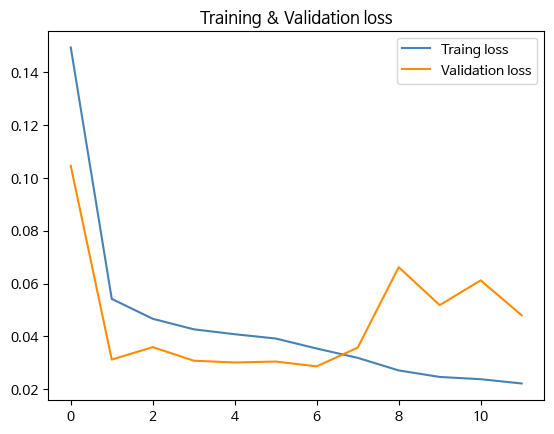

In [47]:
plot_train_history(history=history_ensemble, title='Training & Validation loss')

In [48]:
y_pred_ensemble = model_ensemble.predict([x_test, x_test])

4/4 [==============================] - 1s 7ms/step


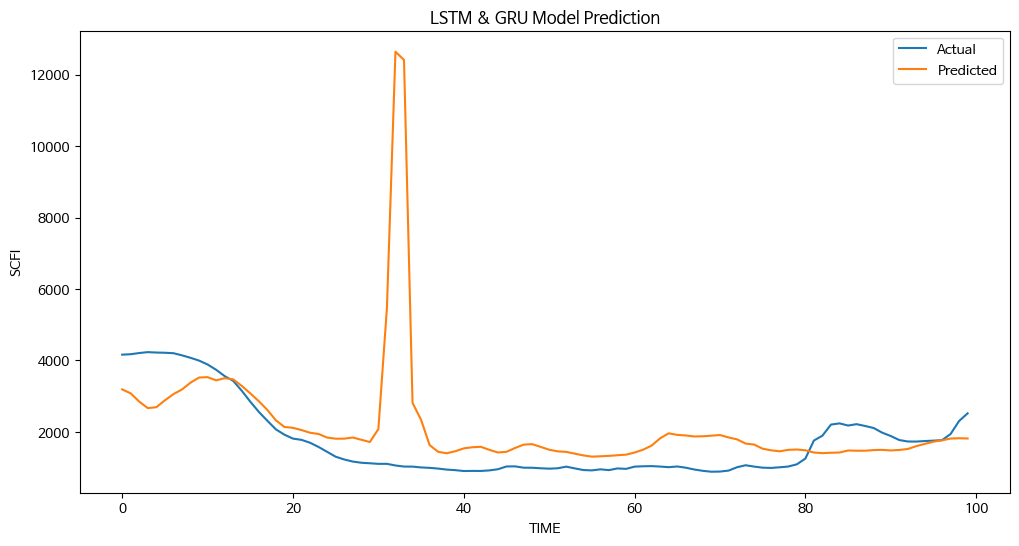

In [49]:
plt.figure(figsize=(12, 6))
plt.plot(np.expm1(scaler_y.inverse_transform(y_test)), label='Actual')
plt.plot(np.expm1(scaler_y.inverse_transform(y_pred_ensemble)), label='Predicted')
plt.title('LSTM & GRU Model Prediction')
plt.xlabel('TIME')
plt.ylabel('SCFI')
plt.legend()
plt.show()

In [50]:
print(f'RMSE: {np.sqrt(mean_squared_error(np.expm1(scaler_y.inverse_transform(y_test)), np.expm1(scaler_y.inverse_transform(y_pred_ensemble))))}')
print(f'MAE : {mean_absolute_error(np.expm1(scaler_y.inverse_transform(y_test)), np.expm1(scaler_y.inverse_transform(y_pred_ensemble)))}')
print(f'R2  : {r2_score(np.expm1(scaler_y.inverse_transform(y_test)), np.expm1(scaler_y.inverse_transform(y_pred_ensemble)))}')

RMSE: 1808.6294158199312
MAE : 839.2221721191406
R2  : -1.9629777779909103


# transformer

In [54]:
data = pd.read_csv('/content/drive/MyDrive/불꽃냥펀치/화이팅.csv', encoding='cp949')

window_size = 3
split = -100

data.drop(columns=['주차'], inplace=True)
data.set_index('날짜', inplace=True)

scaler_1 = MinMaxScaler()
scaler_2 = MinMaxScaler()

X = data.drop(columns=['SCFI'])
feature_np = scaler_1.fit_transform(X)

y = data[['SCFI']]
label_np = scaler_2.fit_transform(y)

X, Y = make_sequence_dataset(feature_np, label_np, window_size)

print(X.shape) # batch_size, time steps, input dims
print(Y.shape)

x_train = X[0:split]
y_train = Y[0:split]
x_test = X[split:]
y_test = Y[split:]

print(x_train.shape, y_train.shape) # batch_size, time steps, input dims
print(x_test.shape, y_test.shape)

(579, 3, 5)
(579, 1)
(479, 3, 5) (479, 1)
(100, 3, 5) (100, 1)


In [55]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, LayerNormalization, MultiHeadAttention, Dropout, Flatten
from tensorflow.keras.models import Model

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    x = LayerNormalization(epsilon=1e-6)(inputs)
    x = MultiHeadAttention(key_dim=head_size, num_heads=num_heads, dropout=dropout)(x, x)
    x = Dropout(dropout)(x)
    res = x + inputs

    x = LayerNormalization(epsilon=1e-6)(res)
    x = Dense(ff_dim, activation="relu")(x)
    x = Dropout(dropout)(x)
    x = Dense(inputs.shape[-1])(x)
    return x + res

def build_transformer_model(input_shape, head_size, num_heads, ff_dim, num_transformer_blocks, mlp_units, dropout=0, mlp_dropout=0):
    inputs = Input(shape=input_shape)
    x = inputs
    for _ in range(num_transformer_blocks):
        x = transformer_encoder(x, head_size, num_heads, ff_dim, dropout)

    x = Flatten()(x)
    for dim in mlp_units:
        x = Dense(dim, activation="relu")(x)
        x = Dropout(mlp_dropout)(x)
    outputs = Dense(1, activation="linear")(x)
    return Model(inputs, outputs)

# 모델 빌드
input_shape = (window_size, 5)  # sequence_length가 10이고 feature가 5인 경우
head_size = 128
num_heads = 2
ff_dim = 128
num_transformer_blocks = 2
mlp_units = [64, 32]
dropout = 0.1
mlp_dropout = 0.1

model_transformer = build_transformer_model(
    input_shape=input_shape,
    head_size=head_size,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    mlp_units=mlp_units,
    dropout=dropout,
    mlp_dropout=mlp_dropout
)

model_transformer.compile(optimizer='adam', loss='mse')

model_transformer.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 3, 5)]               0         []                            
                                                                                                  
 layer_normalization_12 (La  (None, 3, 5)                 10        ['input_4[0][0]']             
 yerNormalization)                                                                                
                                                                                                  
 multi_head_attention_6 (Mu  (None, 3, 5)                 5893      ['layer_normalization_12[0][0]
 ltiHeadAttention)                                                  ',                            
                                                                     'layer_normalization_12

Epoch 1/50
30/30 [==============================] - 8s 35ms/step - loss: 0.0758 - val_loss: 0.0307
Epoch 2/50
30/30 [==============================] - 0s 15ms/step - loss: 0.0551 - val_loss: 0.0638
Epoch 3/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0487 - val_loss: 0.0412
Epoch 4/50
30/30 [==============================] - 0s 11ms/step - loss: 0.0464 - val_loss: 0.0579
Epoch 5/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0333 - val_loss: 0.0211
Epoch 6/50
30/30 [==============================] - 0s 13ms/step - loss: 0.0324 - val_loss: 0.0434
Epoch 7/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0343 - val_loss: 0.0505
Epoch 8/50
30/30 [==============================] - 0s 13ms/step - loss: 0.0371 - val_loss: 0.0584
Epoch 9/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0235 - val_loss: 0.0619
Epoch 10/50
30/30 [==============================] - 0s 12ms/step - loss: 0.0250 - val_loss: 0.0508
Epoch 11/

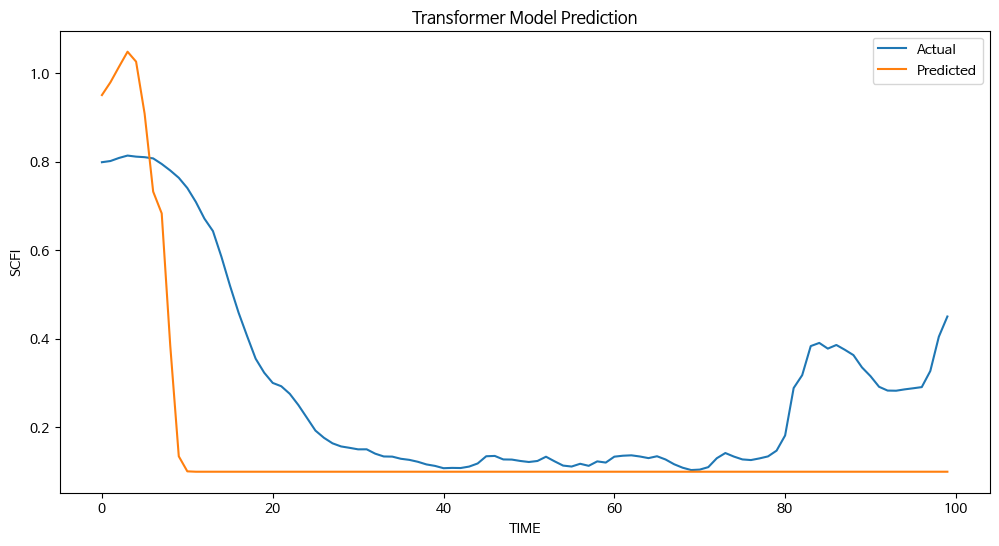

In [56]:
# 모델 학습
history = model_transformer.fit(x_train, y_train, epochs=50, batch_size=16, validation_data=(x_test, y_test))

# 예측 수행
y_pred = model_transformer.predict(x_test)

# 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.title('Transformer Model Prediction')
plt.xlabel('TIME')
plt.ylabel('SCFI')
plt.legend()
plt.show()

In [57]:
print(f'RMSE: {np.sqrt(mean_squared_error(scaler_2.inverse_transform(y_test), scaler_2.inverse_transform(y_pred)))}')
print(f'MAE : {mean_absolute_error(scaler_2.inverse_transform(y_test), scaler_2.inverse_transform(y_pred))}')
print(f'R2  : {r2_score(scaler_2.inverse_transform(y_test), scaler_2.inverse_transform(y_pred))}')

RMSE: 974.8289244750265
MAE : 650.2278661376953
R2  : 0.13923216906337055
